Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [171]:
using HDF5
using Serialization
using DataFrames, Plots, Statistics
using Plots.PlotMeasures 
using DataFramesMeta

In [172]:

function timer_dict_to_df(timer_dict, optimization, flatten=false)
    rows = []

    for (trial, ranks) in timer_dict
        n_important_prt, total_rank, nprt_per_rank, n_float_per_particle, perm = split(trial, ":")
        n_important_prt = n_important_prt == "half" ? "50%" : n_important_prt
        trial_name = "$n_important_prt particles"
        for (rank, timers) in ranks
            function format_row(op, metric, value)
                # if metric == "time_ns"
                #     value = value / 1e6 # Convert nanoseconds to milliseconds
                #     metric = "time_ms"
                # end
                return (
                    optimization = optimization,
                    trial  = String(trial_name),
                    perm = String(perm),
                    total_rank = parse(Int, total_rank),
                    particle_size = n_float_per_particle,
                    nprt_per_rank = nprt_per_rank,
                    rank   = string(rank),
                    op     = String(op),
                    metric = String(metric),
                    value  = value,
                )
            end
            function recursive_push(inner_timers)
                for (op, metrics) in inner_timers
                    if op == "receive loop" && flatten
                        for (inner_op, inner_metrics) in metrics["inner_timers"]
                            for (metric, value) in inner_metrics
                                push!(rows, format_row(inner_op, metric, value))
                            end
                        end
                    else
                        push!(rows, format_row(op, "time_ns", metrics["time_ns"]))
                        push!(rows, format_row(op, "n_calls", metrics["n_calls"]))
                        recursive_push(metrics["inner_timers"])
                    end
                end
            end
            push!(rows, format_row("overall", "time_ns", timers["time_ns"]))
            push!(rows, format_row("overall", "n_calls", timers["n_calls"]))
            recursive_push(timers["inner_timers"])
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 2 methods)

In [173]:
function render(df, label=false)
  trials = unique(df.trial)
  ops    = unique(df.op)

  ntrials, nops = length(trials), length(ops)

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, nops),
    legend = label ? :topleft : :none,
    size       = (300 * nops, 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, op) in enumerate(ops)
      sub = df[(df.trial .== trial) .& (df.op .== op), :]
      for rk in unique(sub.rank)
        subrk = sub[sub.rank .== rk, :]
        scatter!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.time_ms;
          marker     = :circle,
          markersize = 4,
          label      = rk,
          right_margin = 10mm,
          color      = rk == "0" ? :blue : :orange,
        )
      end
      plot!(plt[i, j], title = string(op), top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank")
      end
    end
  end

  display(plt)
  return plt
end

render (generic function with 2 methods)

In [174]:
function df_from_h5(root_dir, category)
    optimization = split(category, "/")[end]

    root = dirname(@__FILE__)
    h5path(rank) = joinpath(root, "../$(root_dir)/$(category)/", "all_timers_$(rank).h5") 
    all_timer_dfs = DataFrame()
    for rank in [2, 4]
        blob = h5open(h5path(rank)) do f
            read(f, "all_timers")
        end

        # Deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
        merged_timers = deserialize(IOBuffer(blob))

        # Convert to DataFrame
        timer_df = timer_dict_to_df(merged_timers, optimization)
        
        # Concat to all_timer_dfs
        all_timer_dfs = vcat(all_timer_dfs, timer_df)
    end

    wide = unstack(
    all_timer_dfs,
    [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank, :op],
    :metric,
    :value
    )

    # Compute the average time per call
    wide.time_ns .= wide.time_ns ./ wide.n_calls
    # Sort by perm and trial
    wide = sort!(wide, [:perm, :trial])

    first_df = wide[wide.perm .== "firstperm", :]
    rand_df = wide[wide.perm .== "randperm", :]
    return (first_df, rand_df)
end

df_from_h5 (generic function with 2 methods)

In [175]:

root_dir = "test/output2"
_, original_100k_df = df_from_h5(root_dir, "original")
# _, dedup_100k_df = df_from_h5("only_dedup")
_, dedup_threads_100k_df = df_from_h5(root_dir, "dedup_threading")
_, op_100k_df = df_from_h5(root_dir, "only_optimize_resampling")
_, dtop_100k_df = df_from_h5(root_dir, "dedup_threading_optimize_resampling")

# union dataframes
union_df = vcat(original_100k_df, dedup_threads_100k_df, op_100k_df, dtop_100k_df)


1187×10 DataFrame
  Row │ optimization                       trial          perm      total_rank ⋯
      │ SubString…                         String         String    Int64      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ original                           1 particles    randperm           2 ⋯
    2 │ original                           1 particles    randperm           2
    3 │ original                           1 particles    randperm           2
    4 │ original                           1 particles    randperm           2
    5 │ original                           1 particles    randperm           2 ⋯
    6 │ original                           1 particles    randperm           2
    7 │ original                           1 particles    randperm           2
    8 │ original                           1 particles    randperm           2
    9 │ original                           1 particles    randperm           2 ⋯
   10 │ original                           1 particles    randperm           2
   11 │ original                           1 particles    randperm           2
  ⋮   │                 ⋮                        ⋮           ⋮          ⋮      ⋱
 1178 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1179 │ dedup_threading_optimize_resampl…  all particles  randperm           4 ⋯
 1180 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1181 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1182 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1183 │ dedup_threading_optimize_resampl…  all particles  randperm           4 ⋯
 1184 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1185 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1186 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 1187 │ dedup_threading_optimize_resampl…  all particles  randperm           4 ⋯
                                                 6 columns and 1166 rows omitted

In [177]:

function widen_ops(df::DataFrame)
    rename!(df, Symbol.(names(df)))

    keys   = [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank]
    wanted = ["overall","waitall","broadcast","copy states","write from buffer","write to buffer",
              "receive loop","send loop","irecv","remote duplicates copy","local copies", "optimize resample"]

    df2 = subset(df, :op => ByRow(in(wanted)))

    transform!(df2, :n_calls => ByRow(x -> x == 0 ? missing : x) => :n_calls)

    g = groupby(df2, vcat(keys, [:op]))
    avg = combine(g,
        [:time_ns, :n_calls] => ((t, c) -> sum(t) / sum(c)) => :time_ns_per_call
    )

    wide = unstack(avg, keys, :op, :time_ns_per_call; combine=first)
    rename!(wide, Symbol.(replace.(string.(names(wide)), " " => "_")))
    return wide
end
union_df = widen_ops(union_df)

120×19 DataFrame
 Row │ optimization                       trial          perm      total_rank  ⋯
     │ SubString…                         String         String    Int64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ original                           1 particles    randperm           2  ⋯
   2 │ original                           1 particles    randperm           2
   3 │ original                           1 particles    randperm           4
   4 │ original                           1 particles    randperm           4
   5 │ original                           1 particles    randperm           4  ⋯
   6 │ original                           1 particles    randperm           4
   7 │ original                           10 particles   randperm           2
   8 │ original                           10 particles   randperm           2
   9 │ original                           10 particles   randperm           4  ⋯
  10 │ original                           10 particles   randperm           4
  11 │ original                           10 particles   randperm           4
  ⋮  │                 ⋮                        ⋮           ⋮          ⋮       ⋱
 111 │ dedup_threading_optimize_resampl…  50% particles  randperm           4
 112 │ dedup_threading_optimize_resampl…  50% particles  randperm           4  ⋯
 113 │ dedup_threading_optimize_resampl…  50% particles  randperm           4
 114 │ dedup_threading_optimize_resampl…  50% particles  randperm           4
 115 │ dedup_threading_optimize_resampl…  all particles  randperm           2
 116 │ dedup_threading_optimize_resampl…  all particles  randperm           2  ⋯
 117 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 118 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 119 │ dedup_threading_optimize_resampl…  all particles  randperm           4
 120 │ dedup_threading_optimize_resampl…  all particles  randperm           4  ⋯
                                                  15 columns and 99 rows omitted

In [178]:
function stats(df_stats)
    df_stats = @chain df_stats[df_stats.total_rank .> 1, :] begin
        @transform(
            :waitall_ratio = :waitall ./ :overall,
            :localcopy_ratio = :local_copies ./ :overall,
            :remotedup_ratio = :remote_duplicates_copy ./ :overall,
            :writefrombuf_ratio = :write_from_buffer ./ :overall,
            :resample_ratio = :optimize_resample ./ :overall,
            :overall_time_log = log2.(:overall),
            :waitall_time_log = log2.(:waitall),
            :copy_states_time_log = log2.(:copy_states)
        )
        groupby([:optimization, :trial, :total_rank])
        @combine(
            :waitall_ratio_mean = mean(:waitall_ratio),
            :localcopy_ratio_mean = mean(:localcopy_ratio),
            :remotedup_ratio_mean = mean(:remotedup_ratio),
            :writefrombuf_ratio_mean = mean(:writefrombuf_ratio),
            :resample_time = mean(skipmissing(:optimize_resample)),
            :overall_log_time_min  = minimum(:overall_time_log),
            :overall_log_time_max  = maximum(:overall_time_log),
            :overall_log_time_mean  = mean(:overall_time_log),
            :copy_states_log_time_min  = minimum(:copy_states_time_log),
            :copy_states_log_time_max  = maximum(:copy_states_time_log),
            :copy_states_log_time_mean  = mean(:copy_states_time_log),
            :waitall_log_time_min  = minimum(:waitall_time_log),
            :waitall_log_time_max  = maximum(:waitall_time_log),
            :waitall_log_time_mean  = mean(:waitall_time_log),
        )
    end
    return df_stats
end

stats (generic function with 1 method)

In [179]:
function render_stats(df, label=false)
  trials = unique(df.trial)

  ntrials = length(trials)
  stats = ["waitall_ratio_mean", "writefrombuf_ratio_mean", "localcopy_ratio_mean", "remotedup_ratio_mean", "overall_log_time_mean", "waitall_log_time_mean", "copy_states_log_time_mean", "resample_time"]

  plt = plot(
    layout     = (ntrials, length(stats)),
    legend = label ? :outertop : :none,
    size       = (300 * length(stats), 300 * ntrials),
  )

  for (i, trial) in enumerate(trials)
    for (j, stat) in enumerate(stats)
      df_filtered = df[df.trial .== trial, :]
      sub = select(df_filtered, :optimization, :total_rank, stat => :value)
      for optimization in unique(sub.optimization)
        subrk = sub[sub.optimization .== optimization, :]
        plot!(
          plt[i, j],
          string.(subrk.total_rank),
          subrk.value;
          seriestype = :path,
          markersize = 4,
          label      = optimization,
          right_margin = 10mm,
          # ylims = (0, maximum(subrk.value) * 1.5)
        )
      end
      plot!(plt[i, j], title = stat, top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank", bottom_margin = 10mm)
      end
    end
  end
  return plt
end

render_stats (generic function with 2 methods)

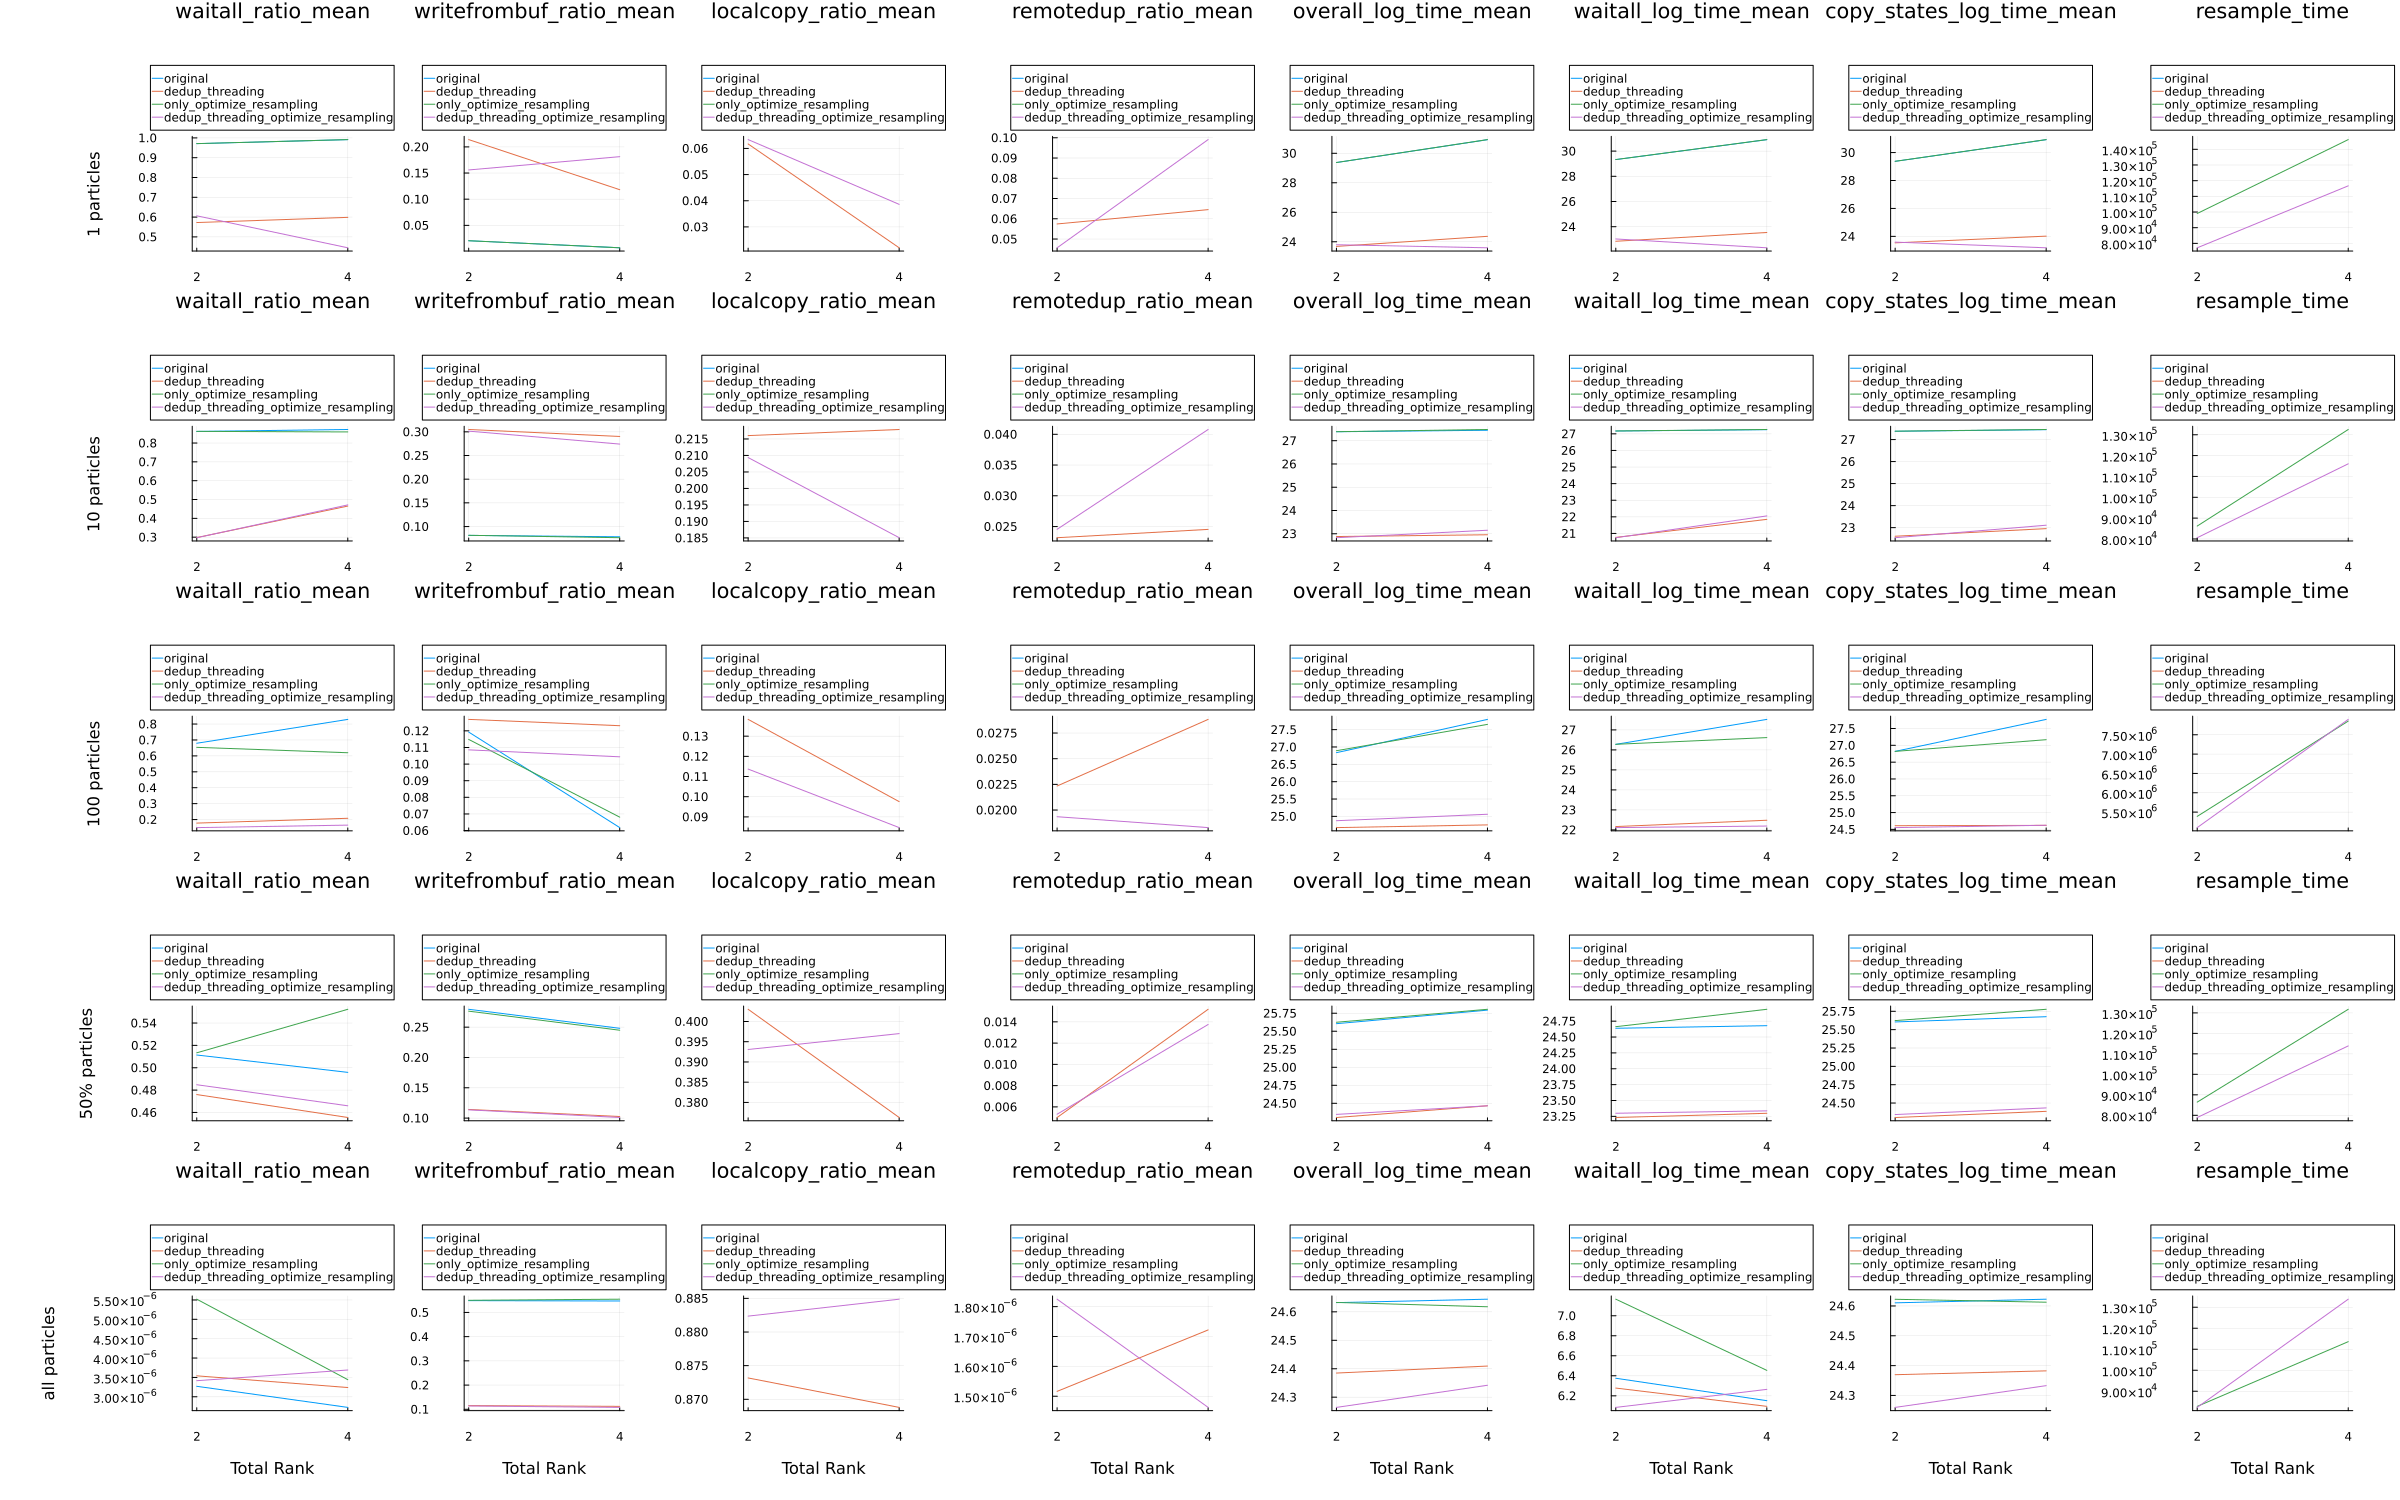

In [180]:
render_stats(stats(union_df), true)